<a href="https://colab.research.google.com/github/Jaesu26/Baekjoon/blob/main/%EC%87%BC%ED%95%91%EB%AA%B0%EB%A6%AC%EB%B7%B0_%ED%8F%89%EC%A0%90_%EB%B6%84%EB%A5%98_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 쇼핑몰 리뷰 평점 분류 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm, tqdm_notebook
from glob import glob
import gc

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [16]:
# !pip install transformers==4.8.2

- 하이퍼파라미터

In [42]:
MODEL_NAME = 'kykim/funnel-kor-base' ## 원하는 model name을 지정하면 된다
SAVE_PATH = './weight3'
NUM_CLASSES = 4
N_FOLD = 5
MAX_LEN = 50
BATCH_SIZE = 128
EPOCHS = 10 
LEARNING_RATE = 1e-5
LABEL_SMOOTHING = 0.05
SEED = 2022

In [46]:
%cd  '/content/drive/MyDrive/Colab Notebooks/쇼핑몰리뷰-평점-분류'

/content/drive/MyDrive/Colab Notebooks/쇼핑몰리뷰-평점-분류


- 가중치 저장폴더

In [7]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [43]:
create_folder(SAVE_PATH)

- 데이터 불러오기

In [9]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [10]:
df.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


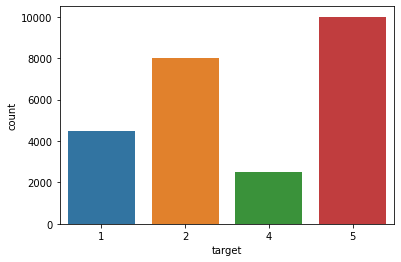

In [11]:
sns.countplot(data=df, x='target')

In [12]:
df['target'] = df['target'].map({1:0, 2:1, 4:2, 5:3})
target = df['target']

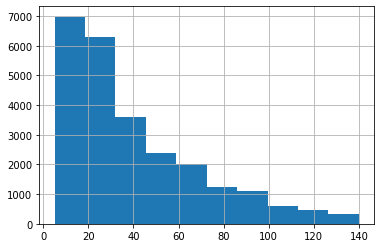

In [13]:
df['reviews'].str.len().hist()

## 텍스트 정제

In [13]:
# pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [23]:
# !pip install emoji==0.6.0
# !pip install soynlp==0.0.493

In [24]:
import re
import emoji
from soynlp.normalizer import repeat_normalize
from pykospacing import Spacing

`-` 텍스트 정제

`-` 코드 참고: https://github.com/Beomi/KcELECTRA

In [27]:
emojis = ''.join(emoji.UNICODE_EMOJI.keys())
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

In [28]:
def clean(x):
    x = pattern.sub(' ', x)
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

In [29]:
df['reviews'] = df['reviews'].apply(clean)
test['reviews'] = test['reviews'].apply(clean)

`-` 띄어쓰기 검사

In [30]:
spacing = Spacing()

In [ ]:
for i in tqdm(range(df.shape[0])):
    df.loc[i, 'reviews'] = spacing(df.loc[i, 'reviews'])

100%|██████████| 25000/25000 [18:48<00:00, 22.15it/s]


In [ ]:
for i in tqdm(range(test.shape[0])):
    test.loc[i, 'reviews'] = spacing(test.loc[i, 'reviews'])

100%|██████████| 25000/25000 [18:41<00:00, 22.29it/s]


In [31]:
# df.to_csv('./Data/clean_df.csv', index=False)
# test.to_csv('./Data/clean_test.csv', index=False)

In [17]:
df = pd.read_csv('./Data/clean_df.csv')
test = pd.read_csv('./Data/clean_test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

## 데이터 셋 및 딥러닝 모델 정의

In [18]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [20]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [21]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True ## 모델과 파라미터가 확정되면 True로 변경
    torch.backends.cudnn.benchmark = True 

In [22]:
seed_everything(SEED) ## 재현을 위한 seed 고정

- 데이터 셋

In [32]:
class CustomDataset(Dataset):
    
    def __init__(self, dataset, model_name, max_len, train_mode=True):
        self.dataset = dataset
        self.max_len = max_len
        self.train_mode = train_mode
        self.tokenizer = AutoTokenizer.from_pretrained(model_name) ## 토크나이저 로드
    
    def __getitem__(self, idx):
        text = self.dataset.loc[idx, 'reviews']
        inputs = self.tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            add_special_tokens=True
            )
        
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        if self.train_mode:
            label = self.dataset.loc[idx, 'target']
            return input_ids, attention_mask, label
        return input_ids, attention_mask

    def __len__(self):
       return len(self.dataset)

- 조기 중단

In [33]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'
            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = None
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, val_acc, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt') ## 모델의 계층별 가중치를 지정한 경로에 저장
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

## 모델 학습

In [34]:
from sklearn.model_selection import StratifiedKFold

In [35]:
skfold = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

In [36]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [37]:
def train(model, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 epoch 하나당 batch들의 평균 훈련 오차를 반환"""
    model.train() ## 훈련모드
    train_avg_loss = 0 ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader) ## 배치 크기

    for input_ids, attention_masks, y in tqdm_notebook(dataloader): ## 미니 배치 단위로 꺼내온다
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        y = y.to(device)

        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = model(input_ids, attention_masks)[0] ## y_hat을 구한다
        loss = loss_fn(yhat, y).to(device) ## 오차를 계산 ## train loss
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch) ## 각 배치마다 훈련 오차 누적

        ## batch마다 학습률 조절
        if scheduler is not None:
            scheduler.step()

    return model, train_avg_loss

In [38]:
def evaluate(model, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 epoch 하나당 batch들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0

    model.eval() ## 평가모드
    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for input_ids, attention_masks, y in tqdm_notebook(dataloader):
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            y = y.to(device)

            yhat = model(input_ids, attention_masks)[0]
            loss = loss_fn(yhat, y) ## valid loss
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader) ## 각 배치마다 평가 오차 누적    

    return valid_avg_loss, valid_avg_acc

In [44]:
net = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES).to(device)

Some weights of the model checkpoint at kykim/funnel-kor-base were not used when initializing FunnelForSequenceClassification: ['decoder.layers.1.ffn.linear_2.bias', 'decoder.layers.0.ffn.linear_1.bias', 'decoder.layers.1.attention.r_s_bias', 'decoder.layers.1.attention.r_w_bias', 'decoder.layers.0.attention.post_proj.weight', 'decoder.layers.0.attention.v_head.bias', 'decoder.layers.0.attention.r_w_bias', 'decoder.layers.1.attention.layer_norm.bias', 'decoder.layers.0.attention.k_head.bias', 'decoder.layers.0.ffn.layer_norm.weight', 'decoder.layers.1.attention.v_head.weight', 'decoder.layers.1.attention.seg_embed', 'decoder.layers.1.attention.layer_norm.weight', 'decoder.layers.0.attention.q_head.weight', 'decoder.layers.0.ffn.linear_1.weight', 'decoder.layers.0.attention.layer_norm.weight', 'decoder.layers.0.attention.r_kernel', 'decoder.layers.1.ffn.linear_2.weight', 'decoder.layers.0.attention.seg_embed', 'decoder.layers.0.ffn.linear_2.bias', 'decoder.layers.1.attention.k_head.weig

In [47]:
torch.save(net.state_dict(), './Data/default_weight.pt') 

`-` fold별로 검증을 할 때마다 동일한 사전학습된 가중치를 가지게 하기 위해 모델을 불러온 후 사전학습된 가중치를 저장

In [49]:
gc.collect()
torch.cuda.empty_cache()

In [50]:
seed_everything(SEED) ## 정확한 loss 재현을 위함
net_avg_acc = [] ## fold별 valid셋의 평균 정확도
net_avg_loss = [] ## fold별 valid셋의 평균 손실
net_epoch_train_loss = [[] for _ in range(N_FOLD)] ## fold별 train셋의 한 epoch당 valid셋의 배치 평균 손실
net_epoch_valid_loss = [[] for _ in range(N_FOLD)] ## fold별 valid셋의 한 epoch당 valid셋의 배치 평균 손실

for i, (train_idx, valid_idx) in enumerate(skfold.split(df, target)):
    gc.collect()
    torch.cuda.empty_cache()
    print(f'[{i + 1} / {N_FOLD}] Fold Training......')
    
    train_data = df.iloc[train_idx].reset_index().drop('index', axis=1)
    valid_data = df.iloc[valid_idx].reset_index().drop('index', axis=1)

    ## early stopping
    early_stopping = EarlyStopping(patience=1,
                                  verbose=False,
                                  path=SAVE_PATH,
                                  n_fold=i+1) ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
    ## 딥러닝 모델
    net.load_state_dict(torch.load('./Data/default_weight.pt', map_location=device)) ## 사전학습된 가중치를 불러온다
    
    ## Dataset, Dataloader
    train_dataset = CustomDataset(train_data, MODEL_NAME, MAX_LEN, train_mode=True)
    valid_dataset = CustomDataset(valid_data, MODEL_NAME, MAX_LEN, train_mode=True)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

    ## optimizer
    optimizer = AdamW(net.parameters(), lr=LEARNING_RATE) ## transformer의 AdamW, 옵티마이저에 최적화할 파라미터와 학습률 전달
                          
    ## scheduler  
    t_total = len(train_dataloader) * EPOCHS  ## The total number of training steps
    warmup_step = int(t_total * 0.1)  ## The number of steps for the warmup phase
    # num_cycles  = 0.5  ## (default = 0.5), The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0 following a half-cosine).
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
    # scheduler = None
    
    ## fold별로 모델 학습
    for epoch in range(EPOCHS): ## (배치사이즈 * 에폭)만큼 훈련시킴
        net, train_avg_loss = train(net, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
        valid_avg_loss, valid_avg_acc = evaluate(net, valid_dataloader, loss_fn)  ## 모델 평가
        net_epoch_train_loss[i].append(train_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
        net_epoch_valid_loss[i].append(valid_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

        if epoch % 1 == 0 or epoch == EPOCHS - 1: 
            ## 1의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}  valid acc = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss, valid_avg_acc)) 
            
        ## epoch마다 early stopping 실행
        early_stopping(net, valid_avg_loss, valid_avg_acc) ## __call__ function
        if early_stopping.early_stop: ## early_stop이 true이면
            if epoch % 1 != 0 and epoch != EPOCHS - 1:
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}  valid acc = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss, valid_avg_acc)) 
            print('Early stopping!')
            break 

    net_avg_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
    net_avg_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
    ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
    
## 마지막으로 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
print(f'{skfold.n_splits} Fold Mean Valid Accuracy: {np.mean(net_avg_acc):.4f}')
print(f'{skfold.n_splits} Fold Mean Valid Loss: {np.mean(net_avg_loss):.4f}')

[1 / 5] Fold Training......


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.1725  valid loss = 0.80196  valid acc = 0.6976


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   2] train loss = 0.79106  valid loss = 0.77604  valid acc = 0.7016


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   3] train loss = 0.75078  valid loss = 0.79207  valid acc = 0.6992
Early stopping!
1 Fold -> Best Valid Loss: 0.7760  Best Valid Accuracy: 0.7016


[2 / 5] Fold Training......


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.1701  valid loss = 0.82821  valid acc = 0.6838


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   2] train loss = 0.79633  valid loss = 0.78315  valid acc = 0.7062


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   3] train loss = 0.75684  valid loss = 0.76699  valid acc = 0.7142


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   4] train loss = 0.73457  valid loss = 0.77415  valid acc = 0.7056
Early stopping!
2 Fold -> Best Valid Loss: 0.7670  Best Valid Accuracy: 0.7142


[3 / 5] Fold Training......


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.1726  valid loss = 0.80892  valid acc = 0.6872


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   2] train loss = 0.79013  valid loss = 0.78535  valid acc = 0.7114


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   3] train loss = 0.74978  valid loss = 0.79303  valid acc = 0.7032
Early stopping!
3 Fold -> Best Valid Loss: 0.7854  Best Valid Accuracy: 0.7114


[4 / 5] Fold Training......


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.1688  valid loss = 0.81801  valid acc = 0.68


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   2] train loss = 0.79134  valid loss = 0.78249  valid acc = 0.704


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   3] train loss = 0.75217  valid loss = 0.78933  valid acc = 0.7082
Early stopping!
4 Fold -> Best Valid Loss: 0.7825  Best Valid Accuracy: 0.7040


[5 / 5] Fold Training......


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.1686  valid loss = 0.81573  valid acc = 0.6934


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   2] train loss = 0.79358  valid loss = 0.80936  valid acc = 0.7082


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   3] train loss = 0.75347  valid loss = 0.78547  valid acc = 0.7042


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   4] train loss = 0.72519  valid loss = 0.78459  valid acc = 0.7038


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:   5] train loss = 0.70173  valid loss = 0.79994  valid acc = 0.6906
Early stopping!
5 Fold -> Best Valid Loss: 0.7846  Best Valid Accuracy: 0.7038


5 Fold Mean Valid Accuracy: 0.7070
5 Fold Mean Valid Loss: 0.7791


## Test 예측

In [51]:
def predict(model, dataloader, weight_save_path, is_prob=False) -> np.array:
    """저장된 모델의 가중치를 불러와서 dataloader의 각 데이터를 예측하여 반환"""
    model = model.to(device) ## device는 전역변수ㅛ
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), len(target.unique()))) ## test예측값, target은 전역변수

    for weight in tqdm(weight_path_list):
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for input_ids, attention_masks in dataloader:
                input_ids = input_ids.to(device)
                attention_masks = attention_masks.to(device)

                outputs = model(input_ids, attention_masks)[0]
                outputs = outputs.cpu().numpy()

                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD) ## N_FOLD는 전역변수
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스

    if is_prob:
        return test_probs ## 각 컬럼별 확률값
    return test_preds ## 라벨값

In [52]:
test_dataset = CustomDataset(test, MODEL_NAME, MAX_LEN, train_mode=False)  
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [53]:
preds = predict(net, test_dataloader, SAVE_PATH)

100%|██████████| 5/5 [07:03<00:00, 84.71s/it]


In [54]:
submission['target'] = preds
submission['target'] = submission['target'].map({0:1, 1:2, 2:4, 3:5})

In [55]:
submission.head()

,id,target
0,0,2
1,1,1
2,2,5
3,3,1
4,4,1


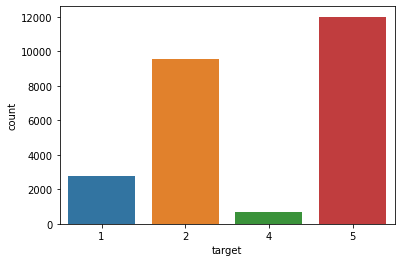

In [57]:
sns.countplot(data=submission, x='target')

In [56]:
submission.to_csv('./Data/submission_funnel2.csv', index=False)